# Markov decision processes (MDPs)

This IPy notebook acts as supporting material for topics covered in **Chapter 17 Making Complex Decisions** of the book* Artificial Intelligence: A Modern Approach*. We makes use of the implementations in mdp.py module. This notebook also includes a brief summary of the main topics as a review. Let us import everything from the mdp module to get started.

Edited by me

In [1]:
from mdp import MDP, GridMDP, sequential_decision_environment, value_iteration

## Review

Before we start playing with the actual implementations let us review a couple of things about MDPs.

- A stochastic process has the **Markov property** if the conditional probability distribution of future states of the process (conditional on both past and present states) depends only upon the present state, not on the sequence of events that preceded it.

    -- Source: [Wikipedia](https://en.wikipedia.org/wiki/Markov_property)

Often it is possible to model many different phenomena as a Markov process by being flexible with our definition of state.
   

- MDPs help us deal with fully-observable and non-deterministic/stochastic environments. For dealing with partially-observable and stochastic cases we make use of generalization of MDPs named POMDPs (partially observable Markov decision process).

Our overall goal to solve a MDP is to come up with a policy which guides us to select the best action in each state so as to maximize the expected sum of future rewards.

## MDP

To begin with let us look at the implementation of MDP class defined in mdp.py The docstring tells us what all is required to define a MDP namely - set of states,actions, initial state, transition model, and a reward function. Each of these are implemented as methods. Do not close the popup so that you can follow along the description of code below.

In [2]:
%psource MDP

The **_ _init_ _** method takes in the following parameters:

- init: the initial state.
- actlist: List of actions possible in each state.
- terminals: List of terminal states where only possible action is exit
- gamma: Discounting factor. This makes sure that delayed rewards have less value compared to immediate ones.

**R** method returns the reward for each state by using the self.reward dict.

**T** method is not implemented and is somewhat different from the text. Here we return (probability, s') pairs where s' belongs to list of possible state by taking action a in state s.

**actions** method returns list of actions possible in each state. By default it returns all actions for states other than terminal states.


Now let us implement the simple MDP in the image below. States A, B have actions X, Y available in them. Their probabilities are shown just above the arrows. We start with using MDP as base class for our CustomMDP. Obviously we need to make a few changes to suit our case. We make use of a transition matrix as our transitions are not very simple.
<img src="files/images/mdp-a.png">

In [3]:
# Transition Matrix as nested dict. State -> Actions in state -> States by each action -> Probabilty
t = {
    "A": {
            "X": {"A":0.3, "B":0.7},
            "Y": {"A":1.0}
         },
    "B": {
            "X": {"End":0.8, "B":0.2},
            "Y": {"A":1.0}
         },
    "End": {}
}

init = "A"

terminals = ["End"]

rewards = {
    "A": 5,
    "B": -10,
    "End": 100
}

In [4]:
class CustomMDP(MDP):

    def __init__(self, transition_matrix, rewards, terminals, init, gamma=.9):
        # All possible actions.
        actlist = []
        for state in transition_matrix.keys():
            actlist.extend(transition_matrix.keys())
        actlist = list(set(actlist))

        MDP.__init__(self, init, actlist, terminals=terminals, gamma=gamma)
        self.t = transition_matrix
        self.reward = rewards
        for state in self.t:
            self.states.add(state)

    def T(self, state, action):
        return [(new_state, prob) for new_state, prob in self.t[state][action].items()]

Finally we instantize the class with the parameters for our MDP in the picture.

In [5]:
our_mdp = CustomMDP(t, rewards, terminals, init, gamma=.9)

With this we have sucessfully represented our MDP. Later we will look at ways to solve this MDP.

## Grid MDP

Now we look at a concrete implementation that makes use of the MDP as base class. The GridMDP class in the mdp module is used to represent a grid world MDP like the one shown in  in **Fig 17.1** of the AIMA Book. The code should be easy to understand if you have gone through the CustomMDP example.



In [6]:
%psource GridMDP

The **_ _init_ _** method takes **grid** as an extra parameter compared to the MDP class. The grid is a nested list of rewards in states.

**go** method returns the state by going in particular direction by using vector_add.

**T** method is not implemented and is somewhat different from the text. Here we return (probability, s') pairs where s' belongs to list of possible state by taking action a in state s.

**actions** method returns list of actions possible in each state. By default it returns all actions for states other than terminal states.

**to_arrows** are used for representing the policy in a grid like format.

We can create a GridMDP like the one in **Fig 17.1** as follows: 

    GridMDP([[-0.04, -0.04, -0.04, +1],
            [-0.04, None,  -0.04, -1],
            [-0.04, -0.04, -0.04, -0.04]],
            terminals=[(3, 2), (3, 1)])
            
In fact the **sequential_decision_environment** in mdp module has been instantized using the exact same code.

In [7]:
sequential_decision_environment

# Value Iteration

Now that we have looked how to represent MDPs. Let's aim at solving them. Our ultimate goal is to obtain an optimal policy. We start with looking at Value Iteration and a visualisation that should help us understanding it better.

We start by calculating Value/Utility for each of the states. The Value of each state is the expected sum of discounted future rewards given we start in that state and follow a particular policy pi.The algorithm Value Iteration (**Fig. 17.4** in the book) relies on finding solutions of the Bellman's Equation. The intuition Value Iteration works is because values propagate. This point will we more clear after we encounter the visualisation. For more information you can refer to **Section 17.2** of the book. 


In [8]:
%psource value_iteration

It takes as inputs two parameters an MDP to solve and epsilon the maximum error allowed in the utility of any state. It returns a dictionary containing utilities where the keys are the states and values represent utilities. Let us solve the **sequencial_decision_enviornment** GridMDP.


In [9]:
value_iteration(sequential_decision_environment)

{(0, 0): 0.2962883154554812,
 (0, 1): 0.3984432178350045,
 (0, 2): 0.5093943765842497,
 (1, 0): 0.25386699846479516,
 (1, 2): 0.649585681261095,
 (2, 0): 0.3447542300124158,
 (2, 1): 0.48644001739269643,
 (2, 2): 0.7953620878466678,
 (3, 0): 0.12987274656746342,
 (3, 1): -1.0,
 (3, 2): 1.0}

## Visualization for Value Iteration

To illustrate that values propagate out of states let us create a simple visualisation. We will be using a modified version of the value_iteration function which will store U over time. We will also remove the parameter epsilon and instead add the number of iterations we want.

In [10]:
def value_iteration_instru(mdp, iterations=20):
    U_over_time = []
    U1 = {s: 0 for s in mdp.states}
    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    for _ in range(iterations):
        U = U1.copy()
        for s in mdp.states:
            U1[s] = R(s) + gamma * max([sum([p * U[s1] for (p, s1) in T(s, a)])
                                        for a in mdp.actions(s)])
        U_over_time.append(U)
    return U_over_time

Next, we define a function to create the visualisation from the utilities returned by **value_iteration_instru**. The reader need not concern himself with the code that immediately follows as it is the usage of Matplotib with IPython Widgets. If you are interested in reading more about these visit [ipywidgets.readthedocs.io](http://ipywidgets.readthedocs.io)

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import defaultdict
import time

def make_plot_grid_step_function(columns, row, U_over_time):
    '''ipywidgets interactive function supports
       single parameter as input. This function
       creates and return such a function by taking
       in input other parameters
    '''
    def plot_grid_step(iteration):
        data = U_over_time[iteration]
        data = defaultdict(lambda: 0, data)
        grid = []
        for row in range(rows):
            current_row = []
            for column in range(columns):
                current_row.append(data[(column, row)])
            grid.append(current_row)
        grid.reverse() # output like book
        fig = plt.imshow(grid, cmap=plt.cm.bwr, interpolation='nearest')

        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

        for col in range(len(grid)):
            for row in range(len(grid[0])):
                magic = grid[col][row]
                fig.axes.text(row, col, "{0:.2f}".format(magic), va='center', ha='center')

        plt.show()
    
    return plot_grid_step

def make_visualize(slider):
    ''' Takes an input a slider and returns 
        callback function for timer and animation
    '''
    
    def visualize_callback(Visualize, time_step):
        if Visualize is True:
            for i in range(slider.min, slider.max + 1):
                slider.value = i
                time.sleep(float(time_step))
    
    return visualize_callback
    

In [12]:
columns = 4
rows = 3
U_over_time = value_iteration_instru(sequential_decision_environment)
           

In [13]:
plot_grid_step = make_plot_grid_step_function(columns, rows, U_over_time)

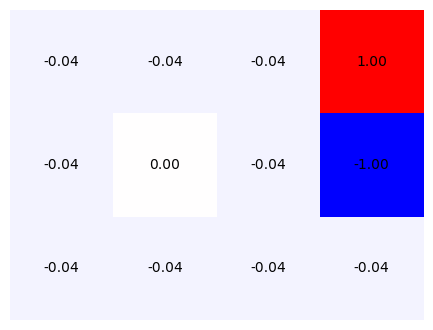

In [15]:
import ipywidgets as widgets
from IPython.display import display

iteration_slider = widgets.IntSlider(min=1, max=15, step=1, value=0)
w=widgets.interactive(plot_grid_step,iteration=iteration_slider)
display(w)

visualize_callback = make_visualize(iteration_slider)

visualize_button = widgets.ToggleButton(desctiption = "Visualize", value = False)
time_select = widgets.ToggleButtons(description='Extra Delay:',options=['0', '0.1', '0.2', '0.5', '0.7', '1.0'])
a = widgets.interactive(visualize_callback, Visualize = visualize_button, time_step=time_select)
display(a)

Move the slider above to observe how the utility changes across iterations. It is also possible to move the slider using arrow keys or to jump to the value by directly editing the number with a double click. The **Visualize Button** will automatically animate the slider for you. The **Extra Delay Box** allows you to set time delay in seconds upto one second for each time step.